<a href="https://colab.research.google.com/github/makkimaki/python-bayes-intro/blob/main/%E3%81%99%E3%82%89%E3%81%99%E3%82%89%E3%83%99%E3%82%A4%E3%82%BA%E5%86%99%E7%B5%8C_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib
!pip install seaborn==0.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
# from IPython.display import display
import seaborn as sns
import pymc as pm
import arviz as az

print(f"{pm.__version__=}")
print(f"{sns.__version__=}")
np.set_printoptions(precision=3, floatmode="fixed")
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.grid"] = True
# pd.options.display.float_format = "[:.3f]".format
pd.set_option("display.max_columns", None)

pm.__version__='5.7.2'
sns.__version__='0.11.0'


# 問題設定
アイリスデータセットから、setosa1のsepal_lengthのデータ分布を求める。

事前分布：正規分布

目標：事後分布を求める。（もっとも確かな分布を求める）

In [3]:
print(sns.get_dataset_names())

[]


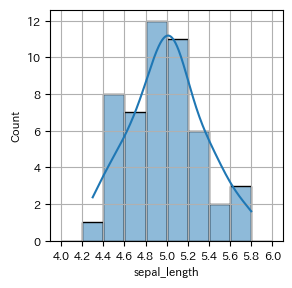

In [4]:
df = sns.load_dataset("iris")
df1 = df.query('species == "setosa"')

bins = np.arange(4.0, 6.2, 0.2)
sns.histplot(df1, x="sepal_length", bins=bins, kde=True)
plt.xticks(bins);

### 具体的にやりたいこと
**平均値、分散の２パラメータの確率分布を推測すること**

In [5]:
display(df.head())

df["species"].value_counts()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

In [6]:
s1 = df1["sepal_length"]

X = s1.values

print(s1.describe())

print(X)

count    50.00000
mean      5.00600
std       0.35249
min       4.30000
25%       4.80000
50%       5.00000
75%       5.20000
max       5.80000
Name: sepal_length, dtype: float64
[5.100 4.900 4.700 4.600 5.000 5.400 4.600 5.000 4.400 4.900 5.400 4.800
 4.800 4.300 5.800 5.700 5.400 5.100 5.700 5.100 5.400 5.100 4.600 5.100
 4.800 5.000 5.000 5.200 5.200 4.700 4.800 5.400 5.200 5.500 4.900 5.000
 5.500 4.900 4.400 5.100 5.000 4.500 4.400 5.000 5.100 4.800 5.100 4.600
 5.300 5.000]


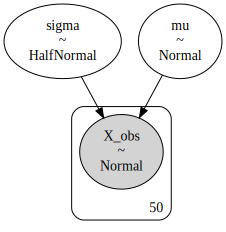

In [7]:
model1 = pm.Model()

with model1:
    mu = pm.Normal("mu", mu=0, sigma=10.0)
    sigma = pm.HalfNormal("sigma", sigma=10.0)
    X_obs = pm.Normal("X_obs", mu=mu, sigma=sigma, observed=X)

g = pm.model_to_graphviz(model1)
display(g)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


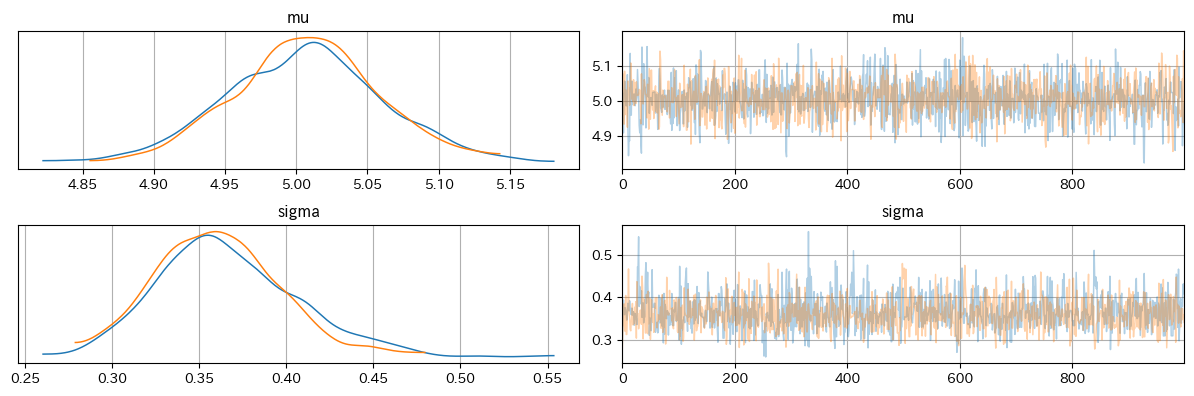

In [8]:
with model1:
    idata1 = pm.sample(random_seed=42)

az.plot_trace(idata1, compact=False)
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.006,0.053,4.908,5.108,0.001,0.001,1988.0,1081.0,1.00
sigma,0.364,0.038,0.289,0.432,0.001,0.001,1619.0,1201.0,1.01


mu=5.006, sigma=0.364


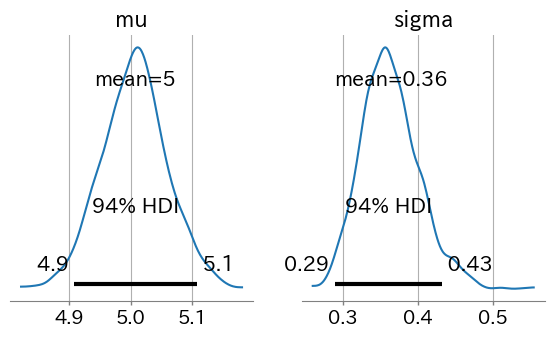

In [9]:
az.plot_posterior(idata1)
summary1 = az.summary(idata1)
display(summary1)

mu_mean1 = summary1.loc["mu", "mean"]
sigma_mean1 = summary1.loc["sigma", "mean"]

print(f"mu={mu_mean1}, sigma={sigma_mean1}")

In [10]:
# ヒストグラムと正規分布関数の重ね書き

def norm(x, mu, sigma):
    y = (x-mu)/sigma
    a = np.exp((-y**2) / 2)
    b = np.sqrt(2*np.pi)*sigma
    return a/b

x_min = X.min()
x_max = X.max()
x_list = np.arange(x_min, x_max, 0.01)
y_list = norm(x_list, mu_mean1, sigma_mean1)

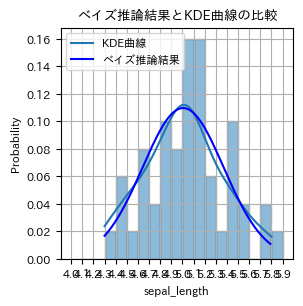

In [11]:
delta = 0.1
bins = np.arange(4.0, 6.0, delta)

fig, ax = plt.subplots()
sns.histplot(df1, ax=ax,
             x="sepal_length",
             bins=bins,
             kde=True,
             stat="probability")
ax.get_lines()[0].set_label("KDE曲線")
ax.set_xticks(bins)
ax.plot(x_list, y_list*delta, c="b", label="ベイズ推論結果")
ax.set_title("ベイズ推論結果とKDE曲線の比較")
plt.legend()
plt.show()

## 線形回帰のベイズ推論
アイリスデータセットにおいて、花の大きさと花弁の長さは一次の相関関係がありそうとみて、モデル設計をする。

求めるもの
- 一時関数の傾き
- 切片

これらをベイズ推論で確率的に求める。

versicolorという花の、萼片の長さ(sepal_length)と幅(sepal_width)1の関係を一次近似する。



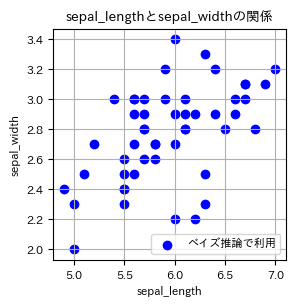

In [12]:
df = sns.load_dataset("iris")

df["species"].value_counts()

df1 = df.query("species == 'versicolor'")

X = df1["sepal_length"]
Y = df1["sepal_width"]

plt.scatter(X, Y, label="ベイズ推論で利用", c="b", marker="o")
plt.legend()
plt.title("sepal_lengthとsepal_widthの関係")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.show()

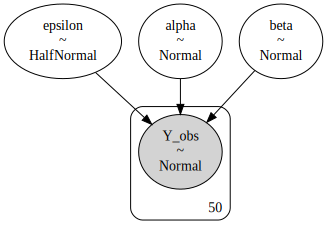

In [13]:
model1 = pm.Model()

with model1:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)

    mu = alpha * X + beta

    epsilon = pm.HalfNormal("epsilon", sigma=1)

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=epsilon, observed=Y)

g = pm.model_to_graphviz(model1)
display(g)


↑しかしここでは、観測値Xが出てきていない（灰色でXが囲まれた領域があるはず）。


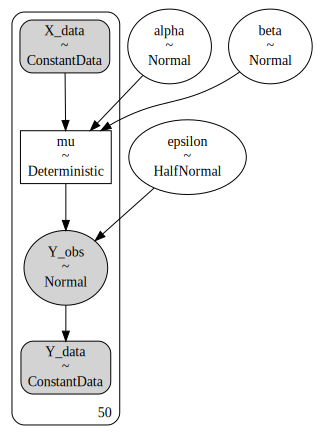

In [14]:
model2 = pm.Model()

with model2:
    X_data = pm.ConstantData("X_data", X)
    Y_data = pm.ConstantData("Y_data", Y)

    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)

    mu = pm.Deterministic("mu", alpha*X_data + beta)
    epsilon = pm.HalfNormal("epsilon", sigma=1)

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=epsilon, observed=Y_data)

g = pm.model_to_graphviz(model2)
display(g)

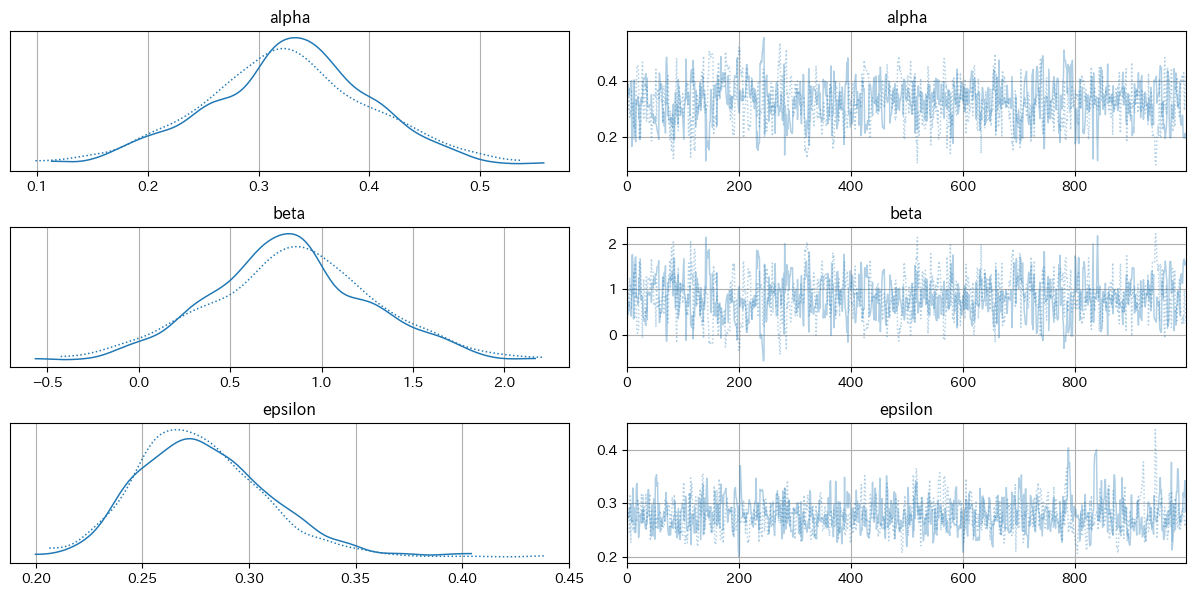

In [15]:
with model2:
    idata2 = pm.sample(random_seed=42)

az.plot_trace(idata2, compact=True, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout()

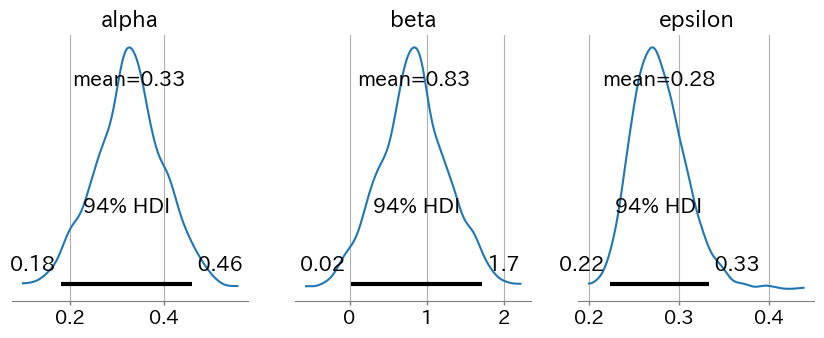

In [16]:
az.plot_posterior(idata2, var_names=["alpha", "beta", "epsilon"]);

## 散布図と回帰直線の重ね書き

In [17]:
x_values = np.array([X.min()-0.1, X.max()+0.1])
print(x_values)
print(x_values.shape)
# alpha2 = idata2["posterior"]["alpha"].values # alpha2.shape=(2,1000)

alpha2 = idata2["posterior"]["alpha"].values.reshape(-1, 1)
beta2 = idata2["posterior"]["beta"].values.reshape(-1, 1)

print(f"{alpha2.shape=}, {beta2.shape=}")

# 以上、ブロードキャストする前準備
y_preds = x_values * alpha2 + beta2
print(y_preds.shape)

[4.800 7.100]
(2,)
alpha2.shape=(2000, 1), beta2.shape=(2000, 1)
(2000, 2)


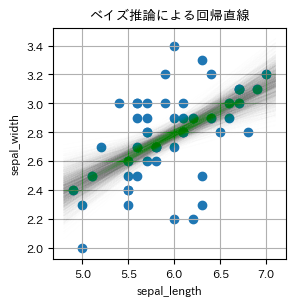

In [18]:
for y_pred in y_preds:
    # print(y_pred)
    plt.plot(x_values, y_pred, lw=1, alpha=0.002, c="g")
plt.scatter(X, Y)

plt.title("ベイズ推論による回帰直線")
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.show()

## 少ない観測値でのベイズ推論
サンプル数=3としてやってみる

In [19]:
import random

random.seed(42)
indexes = range(len(X))
sample_indexes = random.sample(indexes, 3)
print("インデックス値", sample_indexes)

# データ数を3個にする
X_less = X.iloc[sample_indexes]
Y_less = Y.iloc[sample_indexes]
print("xの値: ", X_less.values)
print("yの値: ", Y_less.values)

インデックス値 [40, 7, 1]
xの値:  [5.500 4.900 6.400]
yの値:  [2.600 2.400 3.200]


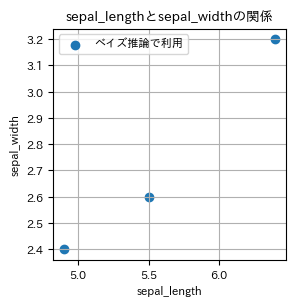

In [20]:
plt.scatter(X_less, Y_less, marker="o", label="ベイズ推論で利用")
plt.title("sepal_lengthとsepal_widthの関係")
plt.legend()
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.show()

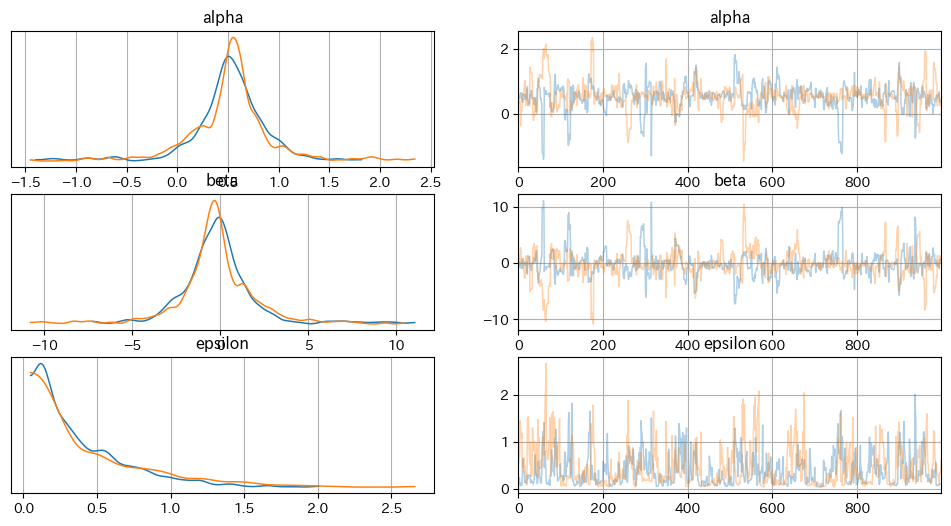

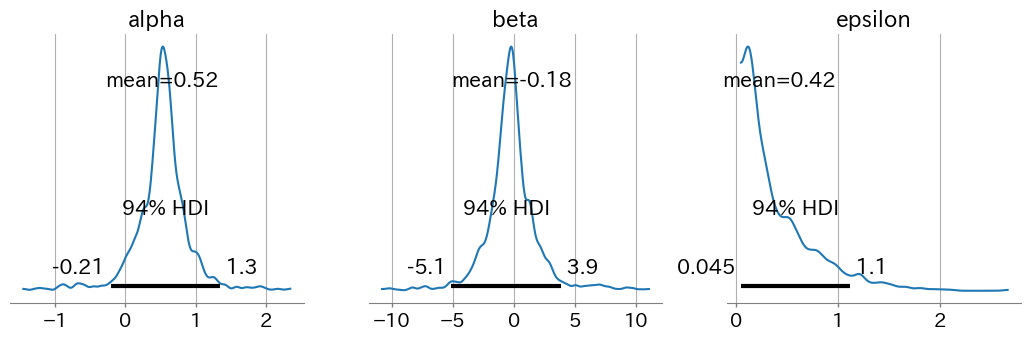

In [21]:
model3 = pm.Model()

with model3:
    X_data = pm.ConstantData("X_data", X_less)
    Y_data = pm.ConstantData("Y_data", Y_less)

    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)

    mu = pm.Deterministic("mu", alpha*X_data + beta)
    epsilon = pm.HalfNormal("epsilon", sigma=1)

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=epsilon, observed=Y_data)

    idata3 = pm.sample(random_seed=42, target_accept=0.995)

az.plot_trace(idata3, compact=False, var_names=["alpha", "beta", "epsilon"])
az.plot_posterior(idata3, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout()
plt.show()

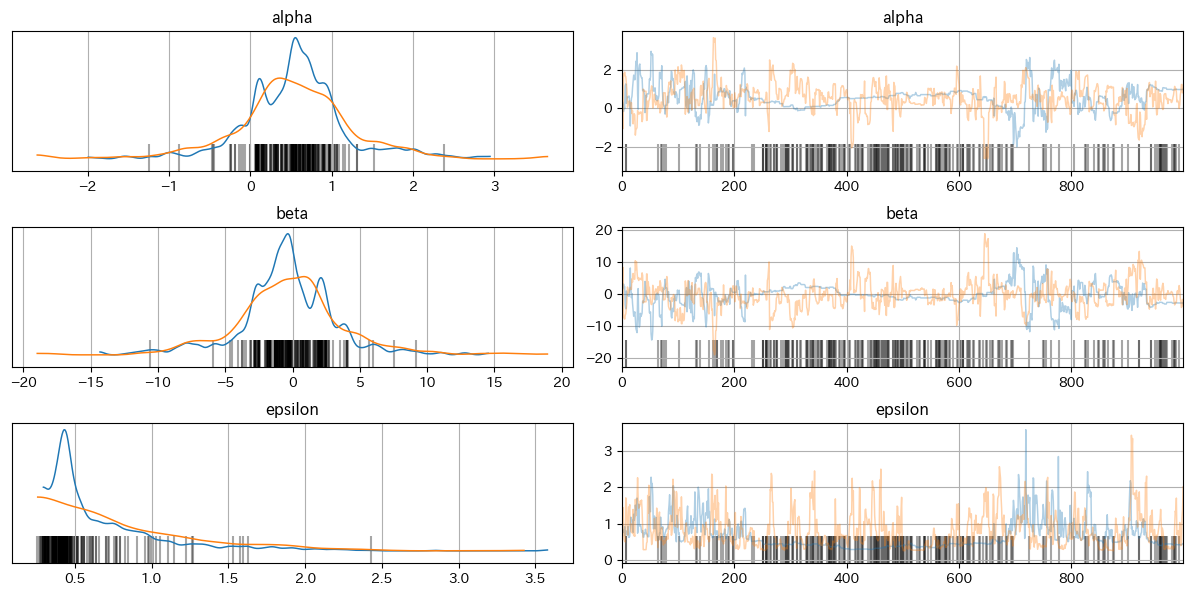

In [22]:
model4 = pm.Model()

with model4:
    X_data = pm.ConstantData("X_data", X_less)
    Y_data = pm.ConstantData("Y_data", Y_less)

    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)

    mu = pm.Deterministic("mu", alpha*X_data + beta)
    epsilon = pm.HalfNormal("epsilon", sigma=1)

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=epsilon, observed=Y_data)

    idata4 = pm.sample(random_seed=42)

az.plot_trace(idata4, compact=False, var_names=["alpha", "beta", "epsilon"])
# az.plot_posterior(idata4, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout()
plt.show()

↑`target_accept`を指定しなかったことで、divergenceが散見されるようになった。


In [23]:
summary4 = az.summary(idata4, var_names=["alpha", "beta", "epsilon"])
display(summary4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.539,0.694,-0.771,1.998,0.064,0.045,105.0,164.0,1.02
beta,-0.286,3.920,-8.304,7.087,0.359,0.255,107.0,181.0,1.02
epsilon,0.744,0.460,0.258,1.683,0.060,0.043,37.0,115.0,1.02


↑ `r_hat`が1.01を上回っている。（1.01を下回ると安定しやすい）

sample関数の`target_accept(default: 0.80)`はこの不安定な時に効きやすい。値を1に近づけることで、うまく行く場合がある。

## 階層ベイズモデル
先ほどの、データ３点のみの例はうまくいった。
しかし、限界はある。

そこで、分析対象の`versicolor`はデータが３つしかないものの、似た傾向のデータ`setosa`, `verginica`についてもそれぞれ３つのデータがあることを利用する。

In [24]:
df = sns.load_dataset("iris")

df["species"].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

In [25]:
df0 = df.query("species == 'setosa'")
df1 = df.query("species == 'versicolor'")
df2 = df.query("species == 'virginica'")

random.seed(42)
indexes = range(len(df1))
sample_indexes = random.sample(indexes, 3)

df0_sel = df0.iloc[sample_indexes]
df1_sel = df1.iloc[sample_indexes]
df2_sel = df2.iloc[sample_indexes]

df_sel = pd.concat([df0_sel, df1_sel, df2_sel]).reset_index(drop=True)
display(df_sel)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.0,3.5,1.3,0.3,setosa
1,5.0,3.4,1.5,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,5.5,2.6,4.4,1.2,versicolor
4,4.9,2.4,3.3,1.0,versicolor
5,6.4,3.2,4.5,1.5,versicolor
6,6.7,3.1,5.6,2.4,virginica
7,7.3,2.9,6.3,1.8,virginica
8,5.8,2.7,5.1,1.9,virginica


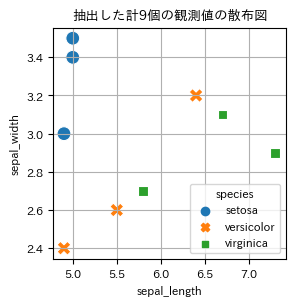

In [26]:
sns.scatterplot(
    x="sepal_length", y="sepal_width",
    hue="species",
    style="species",
    data=df_sel,
    s=100,
)
plt.title("抽出した計9個の観測値の散布図")
plt.show()

In [27]:
X = df_sel["sepal_length"].values
Y = df_sel["sepal_width"].values
species = df_sel["species"]
cl = pd.Categorical(species).codes

print(X)
print(Y)
print(species.values)
print(cl)

[5.000 5.000 4.900 5.500 4.900 6.400 6.700 7.300 5.800]
[3.500 3.400 3.000 2.600 2.400 3.200 3.100 2.900 2.700]
['setosa' 'setosa' 'setosa' 'versicolor' 'versicolor' 'versicolor'
 'virginica' 'virginica' 'virginica']
[0 0 0 1 1 1 2 2 2]


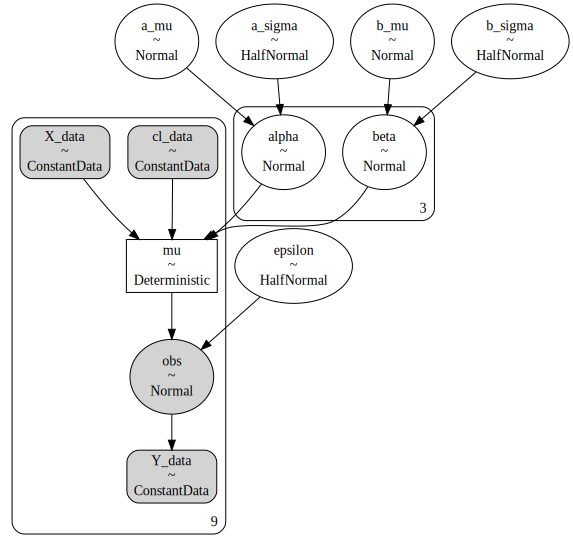

In [28]:
model1 = pm.Model()

with model1:
    X_data = pm.ConstantData("X_data", X)
    Y_data = pm.ConstantData("Y_data", Y)

    cl_data = pm.ConstantData("cl_data", cl)

    a_mu = pm.Normal("a_mu", mu=0, sigma=10)
    a_sigma = pm.HalfNormal("a_sigma", sigma=10)
    alpha = pm.Normal("alpha", mu=a_mu, sigma=a_sigma, shape=(3,))

    b_mu = pm.Normal("b_mu", mu=0, sigma=10)
    b_sigma = pm.HalfNormal("b_sigma", sigma=10)
    beta = pm.Normal("beta", mu=b_mu, sigma=b_sigma, shape=(3,))

    epsilon = pm.HalfNormal("epsilon", sigma=1.0)

    mu = pm.Deterministic("mu", X_data * alpha[cl_data] + beta[cl_data])

    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=Y_data)

g = pm.model_to_graphviz(model1)
display(g)

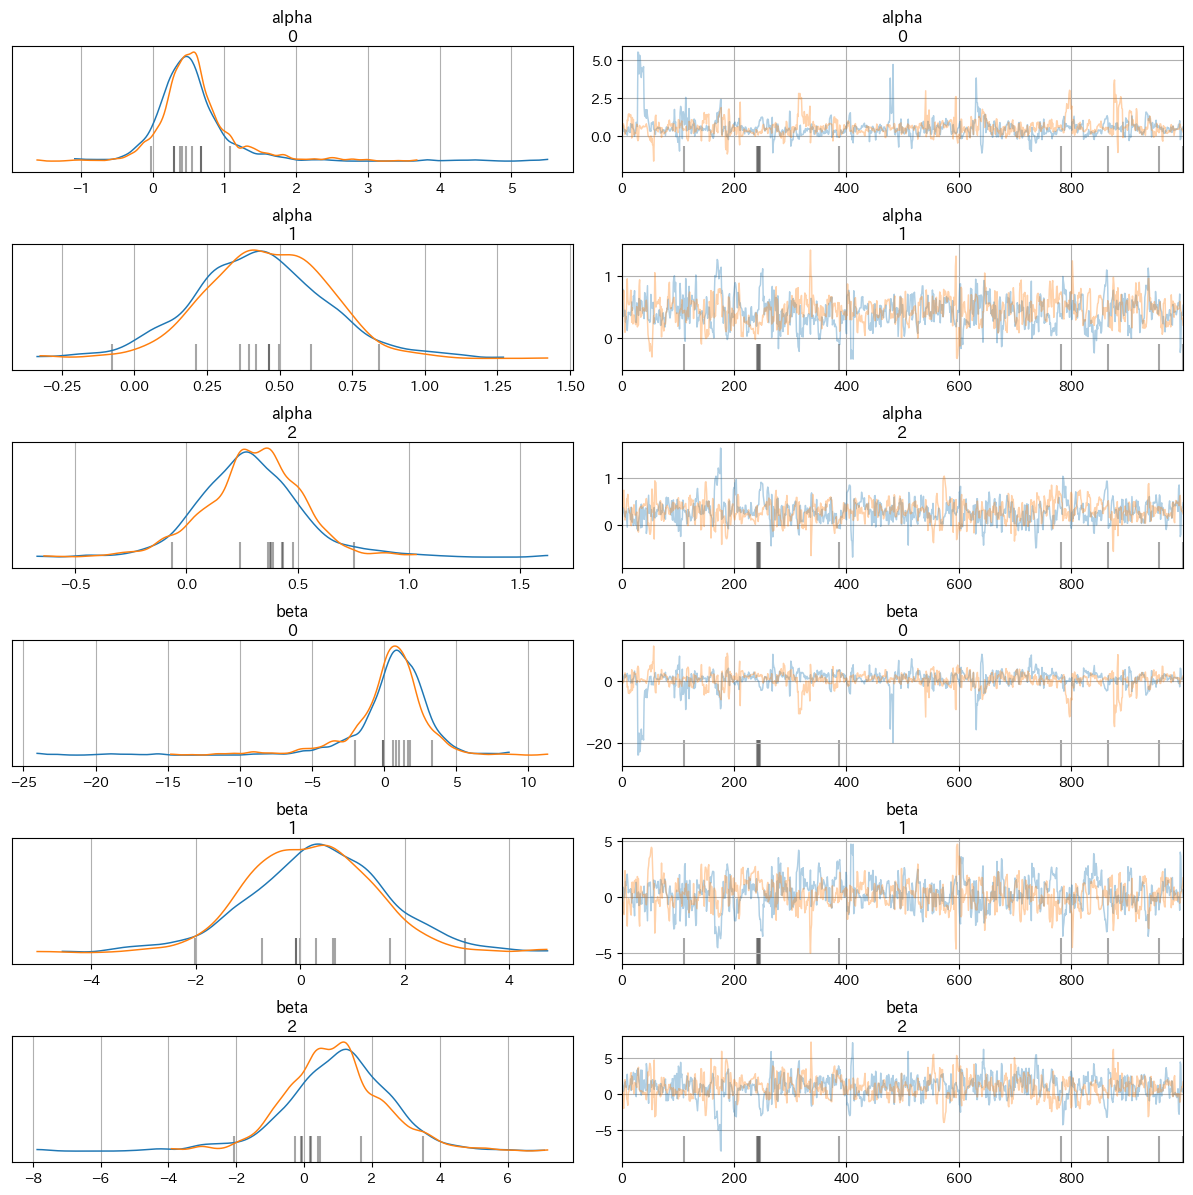

In [29]:
with model1:
    idata1 = pm.sample(random_seed=42, target_accept=0.998)

az.plot_trace(idata1, compact=False, var_names=["alpha", "beta"])
plt.tight_layout();

In [30]:
summary1 = az.summary(idata1, var_names=["alpha", "beta"])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.584,0.598,-0.315,1.608,0.039,0.029,286.0,254.0,1.01
alpha[1],0.443,0.229,0.002,0.862,0.012,0.008,375.0,523.0,1.01
alpha[2],0.296,0.230,-0.118,0.741,0.011,0.009,439.0,400.0,1.00
beta[0],0.384,2.968,-4.654,4.860,0.192,0.140,284.0,263.0,1.01
beta[1],0.267,1.293,-2.158,2.671,0.067,0.048,367.0,578.0,1.01
beta[2],0.950,1.516,-1.731,3.923,0.073,0.052,441.0,452.0,1.00


### 散布図と回帰直線の重ね書き
これまでは可能性のあるすべての回帰直線を書いたが、今回は代表的な回帰直線のみ描画する。（平均値のみ利用）

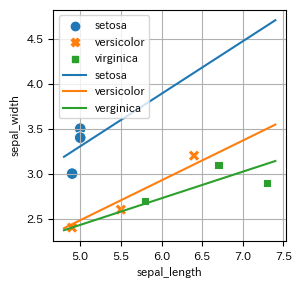

In [31]:
means = summary1["mean"]
alpha0 = means["alpha[0]"]
alpha1 = means["alpha[1]"]
alpha2 = means["alpha[2]"]
beta0 = means["beta[0]"]
beta1 = means["beta[1]"]
beta2 = means["beta[2]"]

x_range = np.array([X.min()-0.1, X.max()+0.1])
y0_range =  alpha0 * x_range + beta0
y1_range =  alpha1 * x_range + beta1
y2_range =  alpha2 * x_range + beta2

sns.scatterplot(
    x="sepal_length",
    y="sepal_width",
    hue="species",
    style="species",
    data=df_sel,
    s=70
)
plt.plot(x_range, y0_range, label="setosa")
plt.plot(x_range, y1_range, label="versicolor")
plt.plot(x_range, y2_range, label="verginica")
plt.legend()
plt.show()

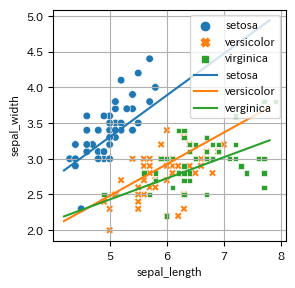

In [32]:
x_range = np.array([
    df["sepal_length"].min() - 0.1,
    df["sepal_length"].max() - 0.1,
    ])
y0_range = alpha0 * x_range + beta0
y1_range = alpha1 * x_range + beta1
y2_range = alpha2 * x_range + beta2

sns.scatterplot(
    x="sepal_length",
    y="sepal_width",
    data=df,
    hue="species",
    style="species",
    s=30
    )
plt.plot(x_range, y0_range, label="setosa")
plt.plot(x_range, y1_range, label="versicolor")
plt.plot(x_range, y2_range, label="verginica")
plt.legend()
plt.show()

↑3点のデータ推論でも、全体のデータに対する良い推論ができていることが見て取れる。階層ベイズモデルの効果。

## 潜在変数モデル
階層ベイズと並んでよく用いられる。

### 問題設定
データ分布に２つのピークがありそう。
アイリスデータセットの例を見てみる。

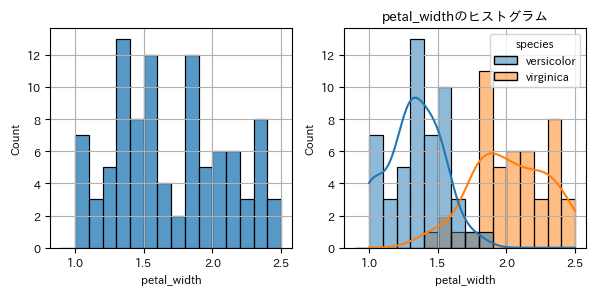

In [33]:
df2 = df.query("species != 'setosa'")
bins = np.arange(df2["petal_width"].min()-0.1, df2["petal_width"].max()+0.1, 0.1)
fig, ax = plt.subplots(1,2, figsize=(6,3))
sns.histplot(
    x="petal_width",
    data=df2,
    bins=bins,
    ax=ax[0],
)
sns.histplot(
    x="petal_width",
    data=df2,
    hue="species",
    bins=bins,
    ax=ax[1],
    kde=True
)
plt.title("petal_widthのヒストグラム")
plt.tight_layout()
plt.show()

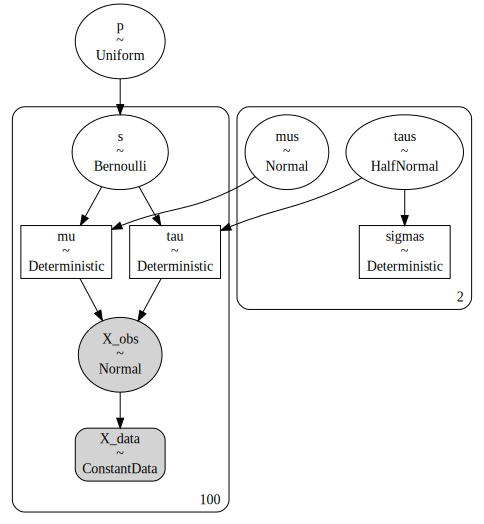

In [34]:
df2 = df2.reset_index(drop=True)

X = df2["petal_width"].values

n_components = 2
N = X.shape

model1 = pm.Model()

with model1:
    X_data = pm.ConstantData("X_data", X)

    p = pm.Uniform("p", lower=0.0, upper=1.0)
    s = pm.Bernoulli("s", p=p, shape=N)

    mus = pm.Normal("mus", mu=0, sigma=10, shape=n_components)
    taus = pm.HalfNormal("taus", sigma=10, shape=n_components)
    sigmas = pm.Deterministic("sigmas", 1/pm.math.sqrt(taus)) #　直接モデルには使用しないが、グラフ描画のためにモデリングしておく

    mu = pm.Deterministic("mu", mus[s])
    tau = pm.Deterministic("tau", taus[s])

    X_obs = pm.Normal("X_obs", mu=mu, tau=tau, observed=X_data)

g = pm.model_to_graphviz(model1)
display(g)

In [35]:
with model1:
    idata1 = pm.sample(
        chains=1,
        draws=2000,
        target_accept=0.99,
        random_seed=42
    )

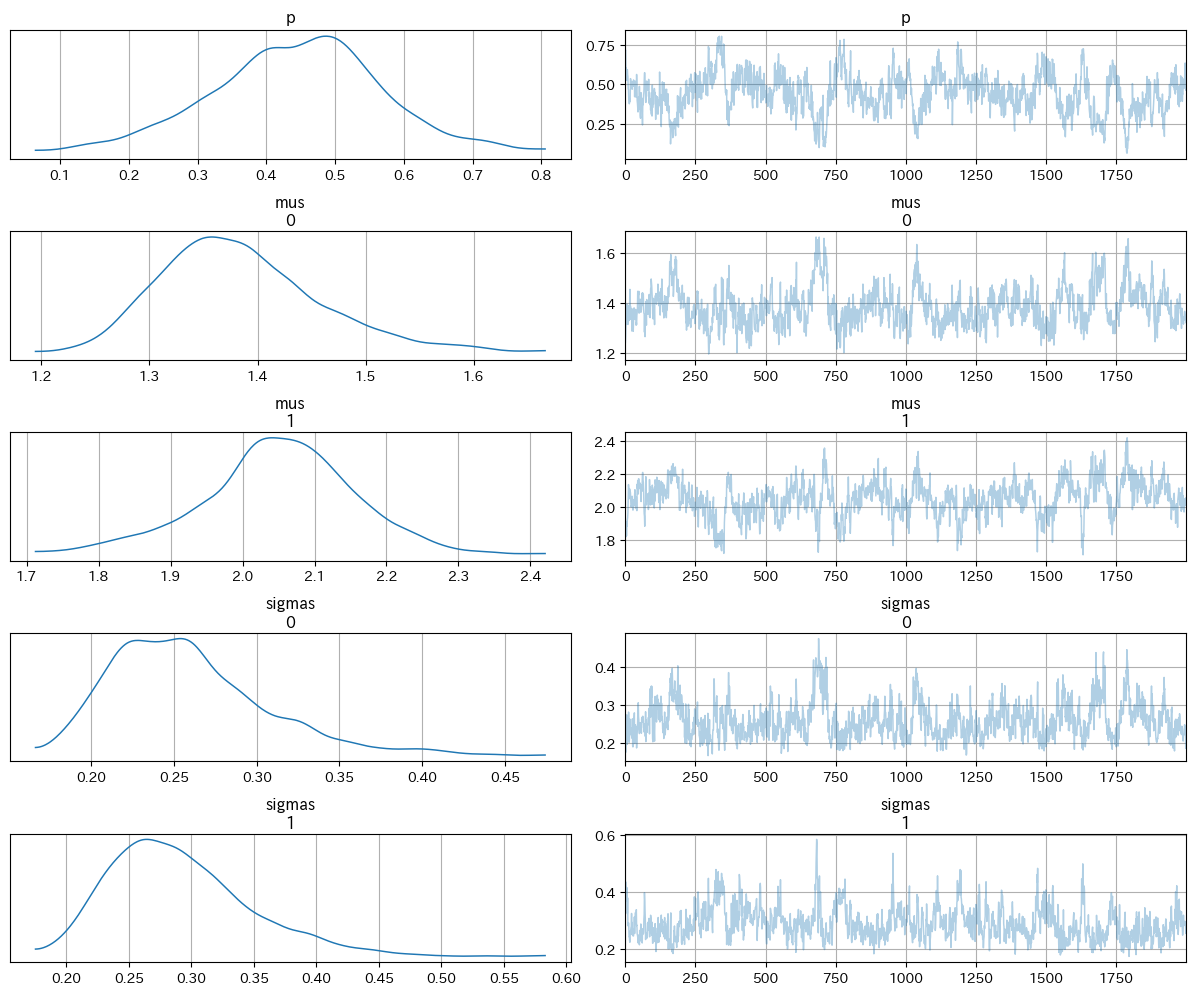

In [36]:
az.plot_trace(idata1, var_names=["p", "mus", "sigmas"], compact=False)
plt.tight_layout()
plt.show()

### 少しだけど観察結果
*   pの事後分布が0.5付近：２クラスそれぞれのサンプル数がおよそ同じ数だけあるため、潜在変数を割り振る確率であるpは0.5付近になることが合理的。
*   リスト項目：mus[0], mus[1]の範囲がそこまで重なっていない。もしラベルスイッチが起きると、重なりが大きくなる。




In [36]:
plt.rcParams["figure.figsize"] = (6,6)
az.plot_posterior(idata1, var_names=["p", "mus", "sigmas"])
plt.tight_layout()

In [37]:
summary1 = az.summary(idata1, var_names=["p", "mus", "sigmas"])
display(summary1)

Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.443,0.125,0.197,0.682,0.015,0.011,66.0,148.0,NaN
mus[0],1.386,0.077,1.255,1.538,0.009,0.006,82.0,113.0,NaN
mus[1],2.050,0.107,1.834,2.247,0.013,0.009,69.0,135.0,NaN
sigmas[0],0.259,0.047,0.178,0.343,0.005,0.004,106.0,139.0,NaN
sigmas[1],0.291,0.056,0.200,0.400,0.006,0.004,88.0,294.0,NaN


### ヒストグラムと正規分布関数の重ね書き
ベイズ推論で得られたパラメータ値に基づく正規分布関数を重ね書きして、確立モデルの当てはまりの良さを評価する。

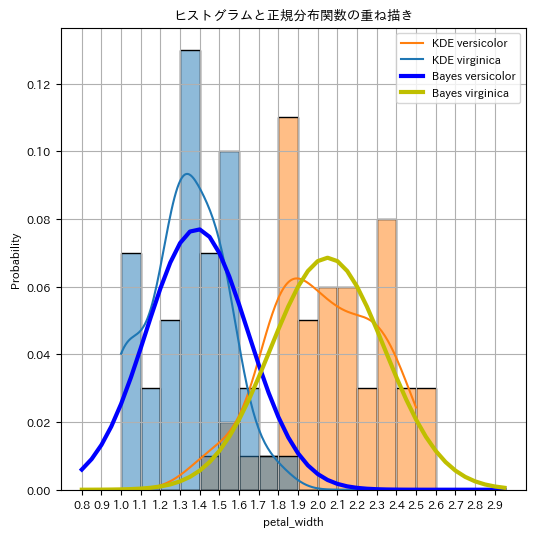

In [43]:
def norm(x, mu, sigma):
    return np.exp(-((x-mu)/sigma)**2/2) / (np.sqrt(2*np.pi)*sigma)

mean = summary1["mean"]

mean_mu0 = mean["mus[0]"]
mean_mu1 = mean["mus[1]"]

mean_sigma0 = mean["sigmas[0]"]
mean_sigma1 = mean["sigmas[1]"]

# 正規分布関数値の計算
x = np.arange(0.8, 3.0, 0.05)
delta = 0.10
y0 = norm(x, mean_mu0, mean_sigma0) * delta / n_components
y1 = norm(x, mean_mu1, mean_sigma1) * delta / n_components

bins = np.arange(0.8, 3.0, delta)
plt.rcParams["figure.figsize"] = (6,6)
fig, ax = plt.subplots()
sns.histplot(
    data=df2,
    bins=bins,
    x="petal_width",
    hue="species",
    kde=True,
    ax=ax,
    stat="probability"
)
ax.get_lines()[0].set_label("KDE versicolor")
ax.get_lines()[1].set_label("KDE virginica")
ax.plot(x, y0, c="b", lw=3, label="Bayes versicolor")
ax.plot(x, y1, c="y", lw=3, label="Bayes virginica")
ax.set_xticks(bins);
# ax.xaxis.set_tick_params(rotation=90)
ax.set_title("ヒストグラムと正規分布関数の重ね描き")
plt.legend()

## 潜在変数の確率分布
２種類の花に対応した正規分布の振る舞いを知ることができた。
さらにもう１つ調べるべきことがある。

⇨潜在変数`s`の振る舞い


モデル構造を再掲
- 潜在変数`s`は観測地ごとに個別の確率分布を持っている。⇨観測地`X_data`の値に応じて、`s`が0 or 1のどちらかに振れる。
- これを`idata1`から調べよう

方法
- `petal_width`が1.0, 1.5, 1.7, 2.0, 2.5である行のインデックスを調べ、それに対応する潜在変数を見る

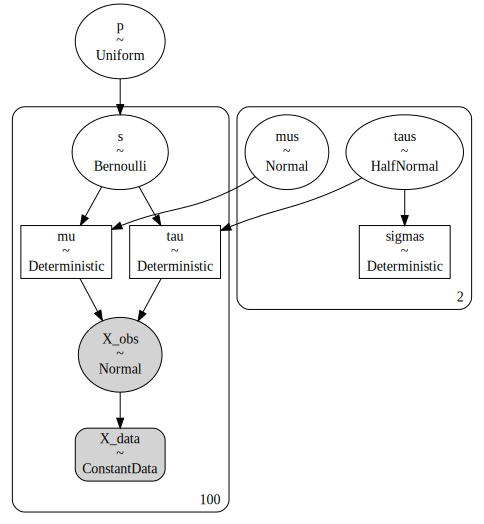

In [44]:
g = pm.model_to_graphviz(model1)
display(g)

In [48]:
value_list = [1.0, 1.5, 1.7, 2.0, 2.5]

df_heads = pd.DataFrame(None)

for value in value_list:

    width = df2.query("`petal_width`==@value", engine="python")

    df_heads = pd.concat([df_heads, width.head(1)], axis=0)

display(df_heads)

,sepal_length,sepal_width,petal_length,petal_width,species
7,4.9,2.4,3.3,1.0,versicolor
1,6.4,3.2,4.5,1.5,versicolor
27,6.7,3.0,5.0,1.7,versicolor
60,6.5,3.2,5.1,2.0,virginica
50,6.3,3.3,6.0,2.5,virginica


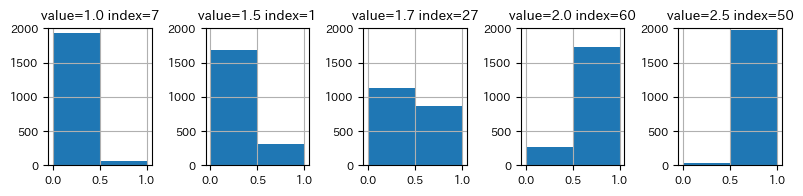

In [56]:
indexes, n_indexes = df_heads.index, len(df_heads)

#潜在変数sのサンプル値から、index=7, 1, 27, 60, 50の値を取得
# sval = idata1.posterior["s"][:,:,indexes].values.reshape(-1, n_indexes).T
sval = idata1.posterior.s[:,:,indexes].values.reshape(-1, n_indexes).T
# sval = idata1["posterior"]["s"][:,:,indexes].values.reshape(-1, n_indexes).T

plt.rcParams["figure.figsize"] = (8, 2)
vlist = df_heads["petal_width"]
fig, axes = plt.subplots(1, n_indexes)
for ax, item, value, index in zip(axes, sval, vlist, indexes):
    f = pd.DataFrame(item)
    f.hist(ax=ax, bins=2)
    ax.set_ylim(0, 2000)
    ax.set_title(f"{value=} {index=}")
plt.tight_layout()
plt.show()